# Facial recognition

#### Images

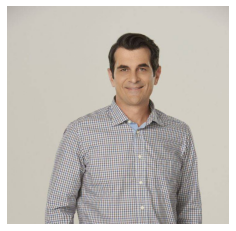

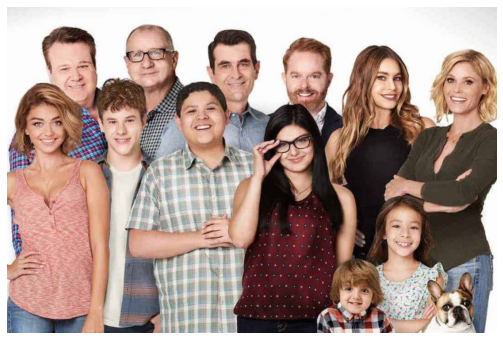

In [9]:
# Read images
# ==============================================================================
from PIL import Image
import cv2
import matplotlib.pyplot as plt

image_1 = Image.open('images/image_1.jpg')
image_2 = Image.open('images/image_2.png')


# Representation of images
# ==============================================================================
plt.figure(figsize=(5, 4))
plt.imshow(image_1)
plt.axis('off');

plt.figure(figsize=(10, 6))
plt.imshow(image_2)
plt.axis('off');

#### Face detector MTCNN

In [10]:
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Detect if cuda GPU is available
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 160,
            device         = device
        )

Running on device: cpu


#### Bounding boxes y facials landmarks

**One face per image**

In [11]:
# Bounding box and landmark detection
# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(image_1, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[345.62845 139.06519 476.7352  315.14072]]
Probability: [0.9999895]
landmarks: [[[383.51602 209.52951]
  [443.06378 206.78795]
  [417.1118  243.22292]
  [387.50204 267.276  ]
  [445.96762 265.4167 ]]]


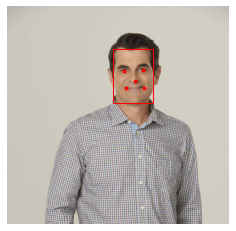

In [12]:
# Rendering with matplotlib
# ==============================================================================
# The origin point (0,0) of an image is the upper left corner
box = boxes[0]
landmark = landmarks[0]
fig, ax  = plt.subplots(figsize=(5, 4))
ax.imshow(image_1)
ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
rect = plt.Rectangle(
            xy     = (box[0], box[1]),
            width  = box[2] - box[0],
            height = box[3] - box[1],
            fill   = False,
            color  = 'red'
       )
ax.add_patch(rect)
ax.axis('off');

#### Multiple faces per image

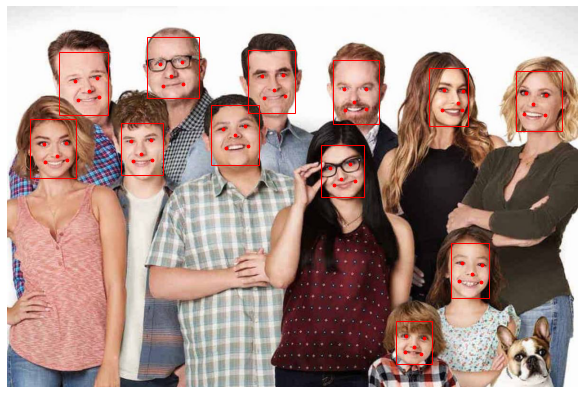

In [13]:
# Bounding box and landmark detection
# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(image_2, landmarks=True)

# Rendering with matplotlib
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(image_2)

for box, landmark in zip(boxes, landmarks):
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
    rect = plt.Rectangle(
                xy     = (box[0], box[1]),
                width  = box[2] - box[0],
                height = box[3] - box[1],
                fill   = False,
                color  = 'red'
           )
    ax.add_patch(rect)
    
ax.axis('off');

#### Face extraction

**One face per image**

In [14]:
# Face detection
# ==============================================================================
face = mtcnn.forward(image_1)

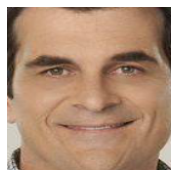

In [15]:
# Rendering with matplotlib
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
face = face.permute(1, 2, 0).int().numpy()
ax.imshow(face)
plt.axis('off');

#### Multiple faces per image

In [16]:
#  MTCNN Detector
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 160,
            device        = device
        )

# Faces detection
# ==============================================================================
faces = mtcnn.forward(image_2)

In [17]:
faces.shape

torch.Size([12, 3, 160, 160])

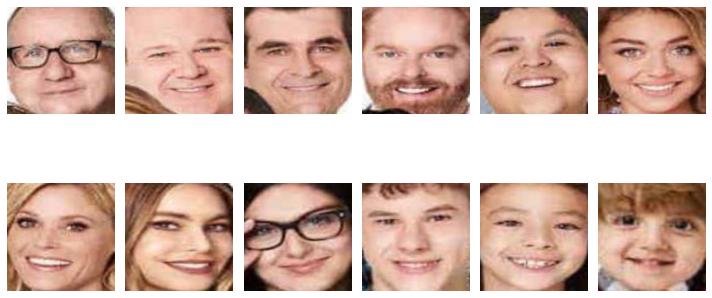

In [18]:
# Rendering with matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(10, 6))
axs= axs.flatten()

for i in range(faces.shape[0]):
    face = faces[i,:,:,:].permute(1, 2, 0).int().numpy()
    axs[i].imshow(face)
    axs[i].axis('off')
    
plt.tight_layout();

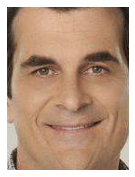

In [19]:
# Face extraction from a bounding box
# ==============================================================================
boxes, probs, landmarks = mtcnn.detect(image_1, landmarks=True)
x1, y1, x2, y2 = boxes[0].astype(int)
recorte_face = np.array(image_1)[y1:y2, x1:x2]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(recorte_face)
plt.axis('off');

#### Face embedding

In [20]:
# Model for embedding the faces
# ==============================================================================
from facenet_pytorch import InceptionResnetV1
encoder = InceptionResnetV1(pretrained='vggface2', classify=False, device=device).eval()

In [21]:
# Face detection
# ==============================================================================
face = mtcnn(image_1)

In [22]:
# Face Embedding
# ==============================================================================
face_embedding = encoder.forward(face.reshape((1,3, 160, 160))).detach().cpu()
face_embedding

tensor([[ 0.0446, -0.0048,  0.0440,  0.0317,  0.0415, -0.0121, -0.0165, -0.0112,
         -0.0145, -0.0414, -0.0882, -0.0074, -0.0864, -0.0183,  0.0820, -0.0564,
          0.0080, -0.0289,  0.0374,  0.0125,  0.0023,  0.0100, -0.0398,  0.0321,
          0.0297,  0.0014,  0.1093,  0.0189,  0.0237, -0.0664,  0.0107,  0.0429,
          0.0220,  0.0070,  0.0179, -0.0002, -0.0732,  0.0410, -0.0307,  0.0210,
          0.0077,  0.0065,  0.0059, -0.1033,  0.0079, -0.0522,  0.0390, -0.0062,
         -0.0294,  0.0126,  0.1046,  0.0949,  0.0677,  0.0620,  0.0100, -0.0214,
          0.0441,  0.0841,  0.0214,  0.0330, -0.0277, -0.0798,  0.0816, -0.0493,
          0.0328,  0.0610,  0.0127, -0.0095,  0.0029, -0.0458,  0.0361, -0.0460,
         -0.0128, -0.0047, -0.0151,  0.0766,  0.0710, -0.0275, -0.0307,  0.0908,
          0.0312,  0.0648,  0.0077, -0.0142,  0.0223, -0.0239,  0.0149, -0.0107,
          0.0276,  0.1006, -0.0224,  0.0581,  0.0438, -0.0444, -0.0482, -0.0134,
         -0.0874,  0.0414, -

#### Similarity between faces

In [23]:
# MTCNN Detector
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 160,
            device        = device
        )


In [24]:
# MTCNN Faces Extraction
# ==============================================================================
phil_1 = mtcnn(image_1)[0]
phil_2 = mtcnn(image_2)[2]
cameron = mtcnn(image_2)[1]

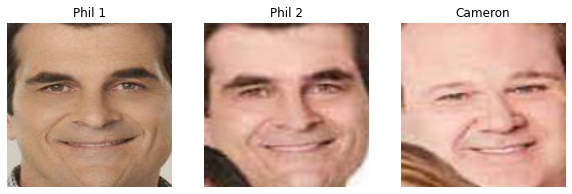

In [25]:
# Rendering with matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

face = phil_1.permute(1, 2, 0).int().numpy()
axs[0].imshow(face)
axs[0].set_title('Phil 1')
axs[0].axis('off')

face = phil_2.permute(1, 2, 0).int().numpy()
axs[1].imshow(face)
axs[1].set_title('Phil 2')
axs[1].axis('off')

face = cameron.permute(1, 2, 0).int().numpy()
axs[2].imshow(face)
axs[2].set_title('Cameron')
axs[2].axis('off');

In [26]:
# Embeddings
# ==============================================================================
embeding_phil_1 = encoder.forward(phil_1.reshape((1,3, 160, 160))).detach().cpu()
embeding_phil_2 = encoder.forward(phil_2.reshape((1,3, 160, 160))).detach().cpu()
embeding_cameron = encoder.forward(cameron.reshape((1,3, 160, 160))).detach().cpu()

In [27]:
# Distances between face embeddings
# ==============================================================================
from scipy.spatial.distance import euclidean
print(f"Distance between the same image Phil: {euclidean(embeding_phil_1, embeding_phil_1)}")
print(f"Distance between the two images of Phil: {euclidean(embeding_phil_1, embeding_phil_2)}")
print(f"Distance between Phil and Cameron: {euclidean(embeding_phil_1, embeding_cameron)}")

Distance between the same image Phil: 0.0
Distance between the two images of Phil: 0.2140313982963562
Distance between Phil and Cameron: 0.3202664256095886


#### Facial recognition pipeline

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import warnings
import typing
import logging
import os
import platform
import glob
import PIL
import facenet_pytorch
from typing import Union, Dict
from PIL import Image
from facenet_pytorch import MTCNN
from facenet_pytorch import InceptionResnetV1
from urllib.request import urlretrieve
from tqdm import tqdm 
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

warnings.filterwarnings('ignore')

logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.WARNING,
)

In [29]:
# Detect face fucntion
# ==============================================================================
def detect_faces(image: Union[PIL.Image.Image, np.ndarray],
                 detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                 keep_all: bool        = True,
                 min_face_size: int    = 20,
                 thresholds: list      = [0.6, 0.7, 0.7],
                 device: str           = None,
                 min_confidence: float = 0.5,
                 fix_bbox: bool        = True,
                 verbose               = False)-> np.ndarray:
    
    # Initial checks
    # --------------------------------------------------------------------------
    if not isinstance(image, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`image` must be `np.ndarray, PIL.Image`. Received {type(image)}."
        )

    if detector is None:
        logging.info('Initializing detector MTCC')
        detector = MTCNN(
                        keep_all      = keep_all,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        post_process  = False,
                        device        = device
                   )
        
    # Faces detection
    # --------------------------------------------------------------------------
    if isinstance(image, PIL.Image.Image):
        image = np.array(image).astype(np.float32)
        
    bboxes, probs = detector.detect(image, landmarks=False)
    
    if bboxes is None:
        bboxes = np.array([])
        probs  = np.array([])
    else:
        # faces with an estimated probability less than `min_confidence` are discarded.
        bboxes = bboxes[probs > min_confidence]
        probs  = probs[probs > min_confidence]
        
    logging.info(f'Total number of faces detected: {len(bboxes)}')
    logging.info(f'Final number of selected faces: {len(bboxes)}')

    # Fix bounding boxes
    #---------------------------------------------------------------------------
    # If any of the corners of the bounding box are outside the image, they are 
    # corrected so that they do not exceed the margins.
    if len(bboxes) > 0 and fix_bbox:       
        for i, bbox in enumerate(bboxes):
            if bbox[0] < 0:
                bboxes[i][0] = 0
            if bbox[1] < 0:
                bboxes[i][1] = 0
            if bbox[2] > image.shape[1]:
                bboxes[i][2] = image.shape[1]
            if bbox[3] > image.shape[0]:
                bboxes[i][3] = image.shape[0]

    # Process information
    # ----------------------------------------------------------------------
    if verbose:
        print("----------------")
        print("scanned image")
        print("----------------")
        print(f"Faces detected: {len(bboxes)}")
        print(f"Correction bounding boxes: {ix_bbox}")
        print(f"Bounding boxes coordinates: {bboxes}")
        print(f"Confidence bounding boxes:{probs} ")
        print("")
        
    return bboxes.astype(int)

In [30]:
# Show boxes function
# ==============================================================================
def show_bboxes(image: Union[PIL.Image.Image, np.ndarray],
                bboxes: np.ndarray,
                identities: list=None,
                ax=None ) -> None:
    
    # Initial checks
    # --------------------------------------------------------------------------
    if not isinstance(image, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`image` must be `np.ndarray, PIL.Image`. Received {type(image)}."
        )
        
    if identities is not None:
        if len(bboxes) != len(identities):
            raise Exception(
                '`identities` must have the same number of elements as `bboxes`.'
            )
    else:
        identities = [None] * len(bboxes)

    # Show the image and overlay bounding boxes
    # --------------------------------------------------------------------------
    if ax is None:
        ax = plt.gca()
        
    if isinstance(image, PIL.Image.Image):
        image = np.array(image).astype(np.float32) / 255
        
    ax.imshow(image)
    ax.axis('off')
    
    if len(bboxes) > 0:
        
        for i, bbox in enumerate(bboxes):
            if identities[i] is not None:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'lime',
                            facecolor = 'none'
                        )
                
                ax.add_patch(rect)
                
                ax.text(
                    x = bbox[0],
                    y = bbox[1] -10,
                    s = identities[i],
                    fontsize = 10,
                    color    = 'lime'
                )
            else:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'red',
                            facecolor = 'none'
                        )
                
                ax.add_patch(rect)
                
        plt.show()
        

In [45]:
# Show boxes cv2 function
# ==============================================================================        
def show_bboxes_cv2(image: Union[PIL.Image.Image, np.ndarray],
                    bboxes: np.ndarray,
                    identities: list=None,
                    device: str='window') -> None:
    
    # Initial checks
    # --------------------------------------------------------------------------
    if not isinstance(image, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`image` must be `np.ndarray`, `PIL.Image`. Received {type(image)}."
        )
        
    if identities is not None:
        if len(bboxes) != len(identities):
            raise Exception(
                '`identities` must have the same number of elements as `bboxes`.'
            )
    else:
        identities = [None] * len(bboxes)

    # Show the image and overlay bounding boxes
    # --------------------------------------------------------------------------      
    if isinstance(image, PIL.Image.Image):
        image = np.array(image).astype(np.float32) / 255
    
    if len(bboxes) > 0:
        
        for i, bbox in enumerate(bboxes):
            
            if identities[i] is not None:
                cv2.rectangle(
                    img       = image,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (0, 255, 0),
                    thickness = 2
                )
                
                cv2.putText(
                    img       = image, 
                    text      = identities[i], 
                    org       = (bbox[0], bbox[1]-10), 
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale = 1e-3 * image.shape[0],
                    color     = (0,255,0),
                    thickness = 2
                )
            else:
                cv2.rectangle(
                    img       = image,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (255, 0, 0),
                    thickness = 2
                )
        
    if device is None:
        return image
    else:
        cv2.imshow(device, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(1) == 27: 
            brcv2.destroyAllWindows()  # esc to close the window
        

In [32]:
# Extraction faces function
# ==============================================================================          
def extract_faces(image: Union[PIL.Image.Image, np.ndarray],
                  bboxes: np.ndarray,
                  output_img_size: Union[list, tuple, np.ndarray]=[160, 160]) -> None:
    
    # Initial checks
    # --------------------------------------------------------------------------
    if not isinstance(image, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`image` must be np.ndarray, PIL.Image. Received {type(image)}."
        )
        
    # Face cutout
    # --------------------------------------------------------------------------
    if isinstance(image, PIL.Image.Image):
        image = np.array(image)
        
    if len(bboxes) > 0:
        faces = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            face = image[y1:y2, x1:x2]
            # Crop resizing
            face = Image.fromarray(face)
            face = face.resize(tuple(output_img_size))
            face = np.array(face)
            faces.append(face)
            
    faces = np.stack(faces, axis=0)

    return faces

In [31]:
# Calculate embeddings function
# ==============================================================================
def calculate_embeddings(img_faces: np.ndarray, encoder=None,
                         device: str=None) -> np.ndarray: 
    
    # Initial checks
    # --------------------------------------------------------------------------
    if not isinstance(img_faces, np.ndarray):
        raise Exception(
            f"`img_faces` must be np.ndarray {type(img_faces)}."
        )
        
    if img_faces.ndim != 4:
        raise Exception(
            f"`img_faces` must be np.ndarray with dimensions [nº faces, width, height, 3]."
            f" Received {img_faces.ndim}."
        )
        
    if encoder is None:
        logging.info('Starting encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()
        
    # Calculation of embedings
    # --------------------------------------------------------------------------
    # The InceptionResnetV1 model requires the input dimensions to be
    # [nº faces, 3, width, height]
    faces = np.moveaxis(img_faces, -1, 1)
    faces = faces.astype(np.float32) / 255
    faces = torch.tensor(faces)
    embeddings = encoder.forward(faces).detach().cpu().numpy()
    embeddings = embeddings
    return embeddings

In [33]:
# Identify faces function
# ==============================================================================
def identify_faces(embeddings: np.ndarray,
                   dict_reference: dict,
                   threshold_similarity: float = 0.6) -> list:
    
    identities = []
        
    for i in range(embeddings.shape[0]):
        # The similarity with each of the reference profiles is calculated.
        similarities = {}
        for key, value in dict_reference.items():
            similarities[key] = 1 - cosine(embeddings[i], value)
        
        # The person with the greatest similarity is identified.
        identity = max(similarities, key=similarities.get)
        # If the similarity < threshold_similarity, it is labeled None
        if similarities[identity] < threshold_similarity:
            identity = None
            
        identities.append(identity)
        
    return identities

In [34]:
# Create reference dictionary function
# ==============================================================================
def create_reference_dictionary(folder_path:str,
                                dict_reference:dict=None,
                                detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                                min_face_size: int=40,
                                thresholds: list=[0.6, 0.7, 0.7],
                                min_confidence: float=0.9,
                                encoder=None,
                                device: str=None,
                                verbose: bool=False)-> dict:
    
    # Initial checks
    # --------------------------------------------------------------------------
    if not os.path.isdir(folder_path):
        raise Exception(
            f"Directory {folder_path} does not exist."
        )
        
    if len(os.listdir(folder_path) ) == 0:
        raise Exception(
            f"Directory {folder_path} is empty."
        )
    
    
    if detector is None:
        logging.info('Initializing detector MTCC')
        detector = MTCNN(
                        keep_all      = False,
                        post_process  = False,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        device        = device
                   )
    
    if encoder is None:
        logging.info('Initializing encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()
        
    
    new_dict_reference = {}
    folders = glob.glob(folder_path + "/*")
    
    for folder in folders:
        
        if platform.system() in ['Linux', 'Darwin']:
            identity = folder.split("/")[-1]
        else:
            identity = folder.split("\\")[-1]
                                     
        logging.info(f'Getting embeddings from: {identity}')
        embeddings = []
        # All images are listed .jpg .jpeg .tif .png
        path_images = glob.glob(folder + "/*.jpg")
        path_images.extend(glob.glob(folder + "/*.jpeg"))
        path_images.extend(glob.glob(folder + "/*.tif"))
        path_images.extend(glob.glob(folder + "/*.png"))
        logging.info(f'Total reference images: {len(path_images)}')
        
        for path_image in path_images:
            logging.info(f'Reading image: {path_image}')
            image = Image.open(path_image)
            # If the image is RGBA it goes to RGB
            if np.array(image).shape[2] == 4:
                image  = np.array(image)[:, :, :3]
                image  = Image.fromarray(image)
                
            bbox = detect_faces(
                        image,
                        detector       = detector,
                        min_confidence = min_confidence,
                        verbose        = False
                    )
            
            if len(bbox) > 1:
                logging.warning(
                    f'More than 2 faces detected in the image: {path_image}. '
                    f'The image from the reference dictionary is discarded.'
                )
                continue
                
            if len(bbox) == 0:
                logging.warning(
                    f'No faces detected in the image: {path_image}.'
                )
                continue
                
            face = extract_faces(image, bbox)
            embedding = calculate_embeddings(face, encoder=encoder)
            embeddings.append(embedding)
        
        if verbose:
            print(f"identity: {identity} --- Reference images: {len(embeddings)}")
            
        embedding_mean = np.array(embeddings).mean(axis = 0)
        new_dict_reference[identity] = embedding_mean
        
    if dict_reference is not None:
        dict_reference.update(new_dict_reference)
        return dict_reference
    else:
        return new_dict_reference
    

In [40]:
# Pipeline detection image function
# ==============================================================================
def pipeline_detection_image(image: Union[PIL.Image.Image, np.ndarray],
                             dict_reference:dict,
                             detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                             keep_all: bool=True,
                             min_face_size: int=20,
                             thresholds: list=[0.6, 0.7, 0.7],
                             device: str=None,
                             min_confidence: float=0.5,
                             fix_bbox: bool=True,
                             output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                             encoder=None,
                             threshold_similarity: float=0.5,
                             ax=None,
                             verbose=False)-> None:
    
    bboxes = detect_faces(
                image          = image,
                detector       = detector,
                keep_all       = keep_all,
                min_face_size  = min_face_size,
                thresholds     = thresholds,
                device         = device,
                min_confidence = min_confidence,
                fix_bbox       = fix_bbox
              )
    
    if len(bboxes) == 0:
        
        logging.info('No faces detected in the image.')
        show_bboxes(
            image       = image,
            bboxes      = bboxes,
            ax          = ax
        )
        
    else:
    
        faces = extract_faces(
                    image  = image,
                    bboxes = bboxes
                )

        embeddings = calculate_embeddings(
                        img_faces = faces,
                        encoder   = encoder
                     )

        identities = identify_faces(
                         embeddings     = embeddings,
                         dict_reference = dict_references,
                         threshold_similarity = threshold_similarity
                       )

        show_bboxes(
            image      = image,
            bboxes      = bboxes,
            identities = identities,
            ax          = ax
        )
    

In [41]:
# Pipeline detection video function
# ==============================================================================    
def pipeline_detection_video(path_input_video: str,
                             dict_reference: dict,
                             path_output_video: str=os.getcwd(),
                             detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                             keep_all: bool=True,
                             min_face_size: int=40,
                             thresholds: list=[0.6, 0.7, 0.7],
                             device: str=None,
                             min_confidence: float=0.5,
                             fix_bbox: bool=True,
                             output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                             encoder=None,
                             threshold_similarity: float=0.5,
                             ax=None,
                             verbose=False)-> None:
    
    # Initial checks
    # --------------------------------------------------------------------------
    if not os.path.isfile(path_input_video):
        raise Exception(
            f"The file {path_input_video} does not exist."
        )
        
        
    capture = cv2.VideoCapture(path_input_video)
    input_frames = []
    output_frames = []

    frame_exist = True
    while(frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_frames.append(frame)
    capture.release()


    for frame in tqdm(input_frames):

        bboxes = detect_faces(
                        image          = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No faces detected in the image.')

            frame_processed = show_bboxes_cv2(
                                image       = frame,
                                bboxes      = bboxes,
                                device      = None
                             )
            output_frames.append(frame_processed)

        else:

            faces = extract_faces(
                        image = frame,
                        bboxes = bboxes
                    )

            embeddings = calculate_embeddings(
                            img_faces = faces,
                            encoder   = encoder
                         )

            identities = identify_faces(
                             embeddings           = embeddings,
                             dict_reference       = dict_references,
                             threshold_similarity = threshold_similarity
                          )

            frame_processed = show_bboxes_cv2(
                                image      = frame,
                                bboxes     = bboxes,
                                identities = identities,
                                device = None
                             )
            output_frames.append(frame_processed)
            
    if len(output_frames) > 0:
        frame_size = (output_frames[0].shape[1], output_frames[0].shape[0])
        out = cv2.VideoWriter(path_output_video, cv2.VideoWriter_fourcc(*'MP4V'), 25, frame_size)

        for frame in output_frames:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        out.release()
            
    return

In [42]:
def pipeline_detection_webcam(dict_reference: dict,
                              output_device: str = 'window',
                              path_output_video: str=os.getcwd(),
                              detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                              keep_all: bool=True,
                              min_face_size: int=40,
                              thresholds: list=[0.6, 0.7, 0.7],
                              device: str=None,
                              min_confidence: float=0.5,
                              fix_bbox: bool=True,
                              output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                              encoder=None,
                              threshold_similarity: float=0.5,
                              ax=None,
                              verbose=False)-> None:
    
    capture = cv2.VideoCapture(0)
    frame_exist = True

    while(frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            capture.release()
            cv2.destroyAllWindows()
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        bboxes = detect_faces(
                        image          = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No faces detected in the image.')
            cv2.imshow(output_device, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                             
        else:

            faces = extract_faces(
                        image  = frame,
                        bboxes = bboxes
                    )

            embeddings = calculate_embeddings(
                            img_faces = faces,
                            encoder   = encoder
                         )

            identities = identify_faces(
                             embeddings           = embeddings,
                             dict_reference       = dict_references,
                             threshold_similarity = threshold_similarity
                          )

            frame_processed = show_bboxes_cv2(
                                image      = frame,
                                bboxes     = bboxes,
                                identities = identities,
                                device     = output_device
                             )
            
        if cv2.waitKey(1) == 27: 
            break  # esc to close the window

    capture.release()
    cv2.destroyAllWindows()

#### Creación del diccionario de referencias

In [23]:
# Descarga de las imágenes de referencia
# ==============================================================================
import urllib
import zipfile

url = ('https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
       'raw/master/images/imagenes_referencia_reconocimiento_facial.zip')

extract_dir = './images/imagenes_referencia_reconocimiento_facial'

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [38]:
# Detect if cuda GPU is available
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Create reference dictionary for each person
# ==============================================================================
dict_references = create_reference_dictionary(
                    folder_path    = './images/imagenes_referencia_reconocimiento_facial',
                    min_face_size  = 40,
                    min_confidence = 0.9,
                    device         = device,
                    verbose        = True
                  )

Running on device: cpu
identity: AlexDunphy --- Reference images: 3
identity: CameronTucker --- Reference images: 2
identity: ClaireDunphy --- Reference images: 3
identity: GloriaPritchett --- Reference images: 3
identity: HaleyDunphy --- Reference images: 4
identity: JayPritchett --- Reference images: 2
identity: JoePritchett --- Reference images: 5
identity: LilyTucker-Pritchett --- Reference images: 4
identity: LukeDunphy --- Reference images: 4
identity: MannyDelgado --- Reference images: 6
identity: MitchellPritchett --- Reference images: 3
identity: PhilDunphy --- Reference images: 4


#### Recognition in images

Running on device: cpu


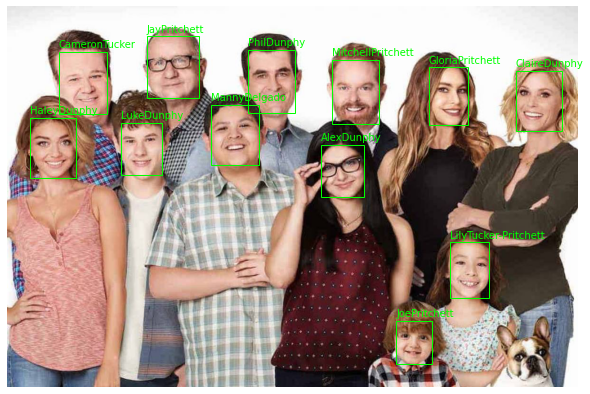

In [43]:
# Recognition in images
# ==============================================================================
# Detect if cuda GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Identify the people in the image
fig, ax = plt.subplots(figsize=(12, 7))
image = Image.open('images/image_2.png')

pipeline_detection_image(
    image = image,
    dict_reference        = dict_references,
    min_face_size         = 20,
    thresholds            = [0.6, 0.7, 0.7],
    min_confidence        = 0.5,
    threshold_similarity = 0.6,
    device                = device,
    ax                    = ax,
    verbose               = False
)

#### Video recognition

In [46]:
# Video recognition
# ==============================================================================
pipeline_detection_video(
    path_input_video      = 'videos/video_modern_family.mp4',
    path_output_video     = 'videos/video_processed.mp4',
    dict_reference        = dict_references,
    threshold_similarity = 0.4,
)

100%|██████████| 1505/1505 [25:54<00:00,  1.03s/it]


#### Recognition in Webcam 

In [49]:
from IPython.display import Video
Video("videos/video_processed.mp4")

In [ ]:
# pipeline_detection_webcam(
#     dict_reference        = dict_references,
#     threshold_similarity = 0.4,
# )